In [1]:
from bggcomplex import *
from lie_algebra_module import *
from quantum_center_module import QuantumFactory
import numpy as np
import scipy
from collections import Counter, defaultdict

In [2]:
BGG = BGGComplex("G2")
BGG.find_cycles();

In [3]:
Solver = BGGMapSolver(BGG,BGG.zero_root)

In [4]:
Solver.solve(parallel=False);

In [5]:
BGG.compute_signs()

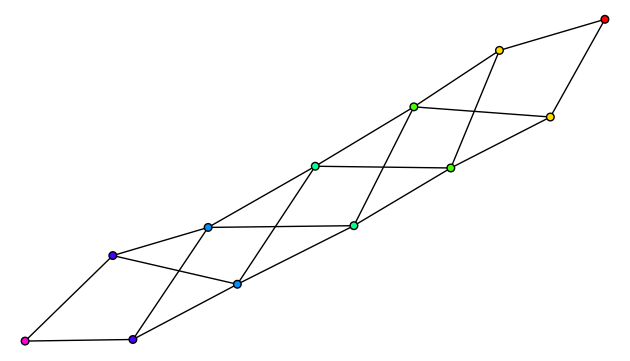

In [6]:
BGG.plot_graph().plot()

We want to implement the $U(\mathfrak g)$ action on the module
$$
    M_i^j=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j+\frac k2}\mathfrak n \right) \right)
$$
For this we need two things, one is finding a basis of this module, and second we define the action on it. Unfortunately I can't find a good out of the box implementation for either of these, so we are going to have to do it ourselves. Ideally we can use this to extend sage a little bit. 

Sagemath has a class FreeModuleTensor, it can deal with alternating and symmetric tensors. But it specifically says it can not deal with tensor products of different modules, whereas that is precisely what we need. We should investigate how this class work, and extend it with this functionality. Besides, that module seems to focus on doing stuff without a specific basis. We want to do everything in a basis, because the whole point is to compute a basis. 

We should make an instance of CombinatorialFreeModule

Next steps:
- compute phi (there is a slight discrepency between this phi and the one in Mathematica. might be because here we choose a more reasonable basis)
- construct M
- construct submodule T
- take quotients by subspaces
- compute dot regular weights
- attach it to BGG complex, compute (co)kernel dimensions

### Definition of coadjoint action

We have a pairing $\langle\,\,,\,\rangle$ on $\mathfrak g$. We also have a map on the root space, ${}^*$ sending:
$e_I \leftrightarrow f_I$, $h_i\leftrightarrow h_i$. Then the coadjoint action, corestricted to a subalgebra $\mathfrak i<\mathfrak g$ with basis $\{\alpha_i\}$,
$$
 \left.\mathrm{ad}^*\right|_{\mathfrak{i}}(X)(m) =- \sum_i\langle m,\,[X,\alpha_i^*] \rangle\alpha_i
$$
The pairing is defined by $\langle e_I,f_I\rangle=\delta_{i,j}$ and $\langle h_i,h_j\rangle=\delta_{i,j}$. We also define
$$
\varphi:\mathfrak b\to\mathfrak n\otimes\mathfrak u,\quad \varphi(m)=\sum_I f_I\otimes \left.\mathrm{ad}^*\right|_{\mathfrak{u}}(m)(e_I)
$$
Note that the image of $\varphi$ is weight zero.

## The module M

Recall:
$$
    M_j^k=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j-r}\mathfrak n \right) \right)
$$

In [7]:
maps = BGG.compute_maps(BGG.zero_root)

In [8]:
q_factory = QuantumFactory(BGG)

In [9]:
def ijk(a,b):
    return (int((a-b)/2),int((a+b)/2),-a)

In [10]:
i,j,k=ijk(6,6)
print(i,j,k)

module = q_factory.M_module(j,k)
relations = q_factory.T_spanning_set(j,k)

(0, 6, -6)


We should have a new class WeightModule which is an extension of LieAlgebraModule, but has the function get_weight. Then we should make a new module, compute_bgg_cohomology which takes a BGG and WeightModule as input to compute BGG.

In [11]:
wtmod = q_factory.weight_module(j,k)

In [12]:
all_weights, regular_weights = BGG.compute_weights(wtmod)

How to compute cohomology:
- We start with a weight module E. Nothing is assumed about it.
- We first of all compute all the dot regular weights of E. 
- For each dot regular weight $\mu$, define the length $\ell(\mu)$ as the length of the unique $w\in W$ such that $w\cdot\mu$ is dominant. 
- We make a list of tuples $(\mu,\,w\cdot \mu,\,\ell(\mu))$
- Let's say we want to compute cohomology in degree i. We create a list $H^i(E)$ = `[ ]`
- We select all $(\mu,\,w\cdot \mu,\,\ell(\mu))$ with $\ell(\mu)=i$
- We compute $H^i(\mathrm{BGG}(E,w\cdot\mu))$
    - If there are no $(\mu',\,w'\cdot \mu',\,\ell(\mu))$ with $w'\cdot\mu'=w\cdot \mu$ and $\ell(\mu')=i\pm 1$, then
    a priori we know that $H^i(\mathrm{BGG}(E,w\cdot\mu)) = E[\mu]$, so we just add $(\mu,\dim E[\mu])$ to the list $H^i(E)$.
    
Now assume that $\lambda=w\cdot \mu$ is a dot-regular dominant weight. 

How to compute $H^i(\mathrm{BGG}(E,\lambda))$:
- Recall that vertices of the BGG graph are labeled by elements $w\in W$. Given a regular (dominant) weight $\mu$ we get can associate to each vertex the $\mathfrak{n}$-module $E[w\cdot \lambda]$. 
- We can also associate to each edge $a\colon w\to w'$ an element $F(a)$ in $U(\mathfrak n)$ and a sign $\sigma(a)\in\{+1,-1\}$. We have $F(a)\cdot E[w\cdot \lambda]\subset E[w'\cdot \lambda]$.
- We define the column $\mathrm{BGG}_i = \bigoplus_{\ell(w)=i}E[w\cdot \lambda]$
- We define the map $\delta\colon\mathrm{BGG}_i\to\mathrm{BGG}_{i+1}$ by $\sum_{\ell(w)=i}\sum_{s(a)=w}\sigma(a)F(a)$
- We want to compute $\dim H^i = \dim \ker \delta_i - \dim \,\mathrm{coker} \delta_{i-1} =\dim\ker\delta_i-\dim \mathrm{BGG}_i+\dim\ker\delta_{i-1}^\top$
- Actually these are the maps on the weight module $M$, but we need them on $E$. For each weight we have a short exact sequence $T^j_k[\mu]\to M^j_k[\mu]\to E^j_k[\mu]$. We need to find the projection/section here. Call the section $s_\mu:E^j_k[\mu]\to M^j_k[\mu]$. Then we need to compute the kernels of the maps
$$\widetilde{\delta}_i= \sum_{\ell(w)=i}\sum_{a\colon w\to w'}s_{w'\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w\cdot \lambda}$$
$$\widetilde{\delta}^\top_{i-1}= \sum_{\ell(w)=i}\sum_{a\colon w'\to w}s_{w\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w'\cdot \lambda}$$

In [13]:
weight = BGG.zero_root

In [14]:
maps = BGG.compute_maps(weight)
column = BGG.column[i]
delta_i_arrows = [(w,[arrow for arrow in BGG.arrows if arrow[0]==w]) for w in column]
delta_i_1_arrows = [(w,[arrow for arrow in BGG.arrows if arrow[1]==w]) for w in column]

In [15]:
vertex_weights = dict()
for w,reflection in BGG.reduced_word_dic.items():
    new_weight = BGG.weight_to_alpha_sum(reflection.action(weight+BGG.rho)-BGG.rho)
    vertex_weights[w]=new_weight
vertex_weights

{'': 0,
 '1': -alpha[1],
 '12': -4*alpha[1] - alpha[2],
 '121': -6*alpha[1] - 2*alpha[2],
 '1212': -9*alpha[1] - 4*alpha[2],
 '12121': -10*alpha[1] - 5*alpha[2],
 '2': -alpha[2],
 '21': -alpha[1] - 2*alpha[2],
 '212': -4*alpha[1] - 4*alpha[2],
 '2121': -6*alpha[1] - 5*alpha[2],
 '21212': -9*alpha[1] - 6*alpha[2],
 '212121': -10*alpha[1] - 6*alpha[2]}

In [16]:
def section_transpose_image(section,monomial_coeffs,section_index):
    """computes the image of the tranpose of the section, reports the coefficients as (index,row_number) where 
    index is supplied and should be the w' vertex of BGG, and row_number is the number of the row of the section"""
    output = Counter()
    for row_index,row in enumerate(section):
        for monomial_key, monomial_coeff in monomial_coeffs.items():
            if monomial_key in row:
                output[(section_index,row_index)]+=row[monomial_key]*monomial_coeff
    return output
            

In [28]:
def bgg_differential(self, maps, i):
    """Compute the BGG differential $\tilde \delta_i: E_i\to E_{i+1}$ on the quotient weight module."""
    
    # Get vertices of the ith column
    column = self.column[i]
    
    # Find all the arrows going from ith column to (i+1)th column in form (w, [w->w',w->w'',...])
    delta_i_arrows = [(w, [arrow for arrow in self.arrows if arrow[0]==w]) for w in column]
    
    # Initialize output. Since there could be two arrows with the same target, we use counter to sum results.
    output_dic = defaultdict(Counter)
    
    for initial_vertex,arrows in delta_i_arrows:
        # Get the section for the initial weight w
        initial_section = wtmod.get_section(vertex_weights[initial_vertex])
        
        #for index,_ in enumerate(initial_section):
        #    output_dic[(initial_vertex,index)]=Counter()
        
        # Compute $s_w'^\top \sigma(a) F(a) \,s_w$ for each a:w->w'
        for a in arrows:
            sign = BGG.signs[a]
            pbw = maps[a]
            final_section = wtmod.get_section(vertex_weights[a[1]])
            
            # Compute image for each row of the initial_section, add results together
            for index,row in enumerate(initial_section):
                
                # First the image of the row without applying the transpose section
                image_before_section = Counter()
                
                # Compute the action of the PBW element on each of the basis components 
                # of the row of the section and add the result together
                for key,coeff in row.items():
                    action_on_element = wtmod.pbw_action(pbw,wtmod.basis()[key])
                    action_on_element = wtmod.action(pbw,wtmod.basis()[key])

                    action_on_element *= coeff*sign
                    monomial_coeffs = action_on_element.monomial_coefficients()

                    for mon_key, mon_coeff in monomial_coeffs.items():
                        image_before_section[mon_key]+=mon_coeff

                # Compute the image of the row under the tranpose section, add the result to the output
                if len(image_before_section)>0:
                    final_image = section_transpose_image(final_section,image_before_section,a[1])
                    output_dic[(initial_vertex,index)]=output_dic[(initial_vertex,index)]+final_image
    return dict(output_dic)

In [48]:
output_dic = bgg_differential(BGG, maps, i)

In [49]:
def vectorize_dictionaries(list_of_dics):
    if isinstance(list_of_dics,dict):
        list_of_dics=list_of_dics.values()
    keys = set()
    for dic in list_of_dics:
        for key in dic.keys():
            keys.add(key)
    key_map = {key:i for i,key in enumerate(keys)}
    
    output  = matrix(ZZ,len(output_dic),len(image_dict))
    for row_number,row in enumerate(list_of_dics):
        for key,value in row.items():
            output[row_number,key_map[key]] = value
    return output
delta_i_matrix = vectorize_dictionaries(output_dic)
len(output_dic)-delta_i_matrix.rank()

1